In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sqlalchemy

username = "postgres"
password = "postgres"
endpoint = "crypto-warehouse.cdvabacdldda.us-west-1.rds.amazonaws.com" 
dbname   = "BitcoinDataMart"

con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

df = pd.read_sql("SELECT * FROM bitcoin_datamart_data", con)
print(pd.__version__)
df.head()

1.3.5


,column1,unix,Open,high,low,Close,volume-coin,volume-usd,weighted_price,date,just_date,just_time
0,0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00,2011-12-31,07:52:00
1,1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00,2011-12-31,07:53:00
2,2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00,2011-12-31,07:54:00
3,3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00,2011-12-31,07:55:00
4,4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00,2011-12-31,07:56:00


In [ ]:
# Unix-time to 
df.date = pd.to_datetime(df.date)

# Resampling to daily frequency
df.index = df.date
df['my_weighted_avg'] = df[['high','low','Close']].mean(axis=1)

df = df.resample('D').mean()

# # Resampling to monthly frequency
df_month = df.resample('M').mean()

# # Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# # Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()
df.columns


df.head()

,column1,unix,Open,high,low,Close,volume-coin,volume-usd,weighted_price,my_weighted_avg
date,,,,,,,,,,
2011-12-31,483.5,1.325347e+09,4.465000,4.482500,4.465000,4.482500,23.829469,106.330085,4.471603,4.476667
2012-01-01,1687.5,1.325419e+09,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667
2012-01-02,3127.5,1.325506e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000
2012-01-03,4567.5,1.325592e+09,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500
2012-01-04,6007.5,1.325678e+09,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.215556


Dickey–Fuller test: p=0.998862


<Figure size 1080x1440 with 0 Axes>

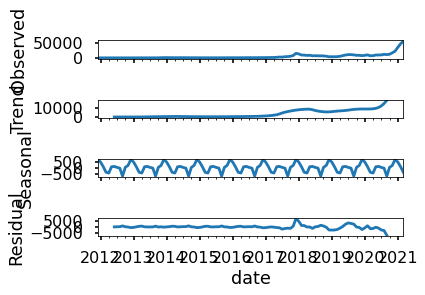

In [ ]:

plt.figure(figsize=[15,20])
sm.tsa.seasonal_decompose(df_month.my_weighted_avg).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.my_weighted_avg)[1])
plt.show()

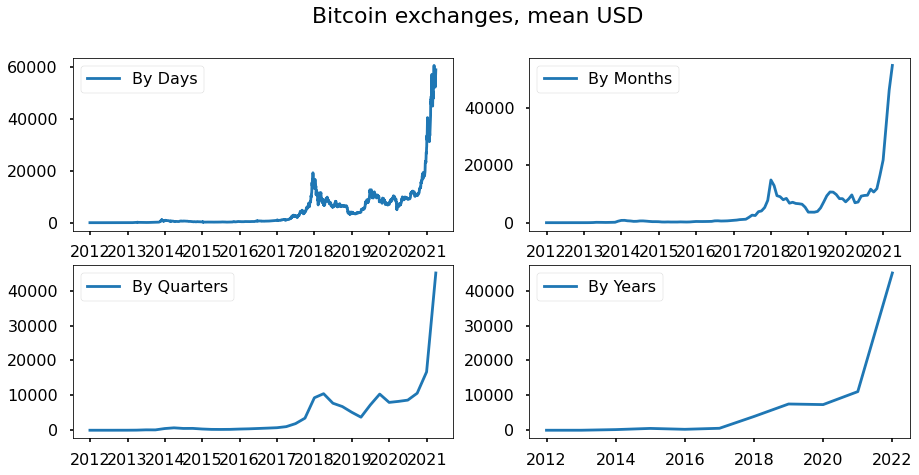

In [ ]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.my_weighted_avg, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.my_weighted_avg, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.my_weighted_avg, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.my_weighted_avg, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

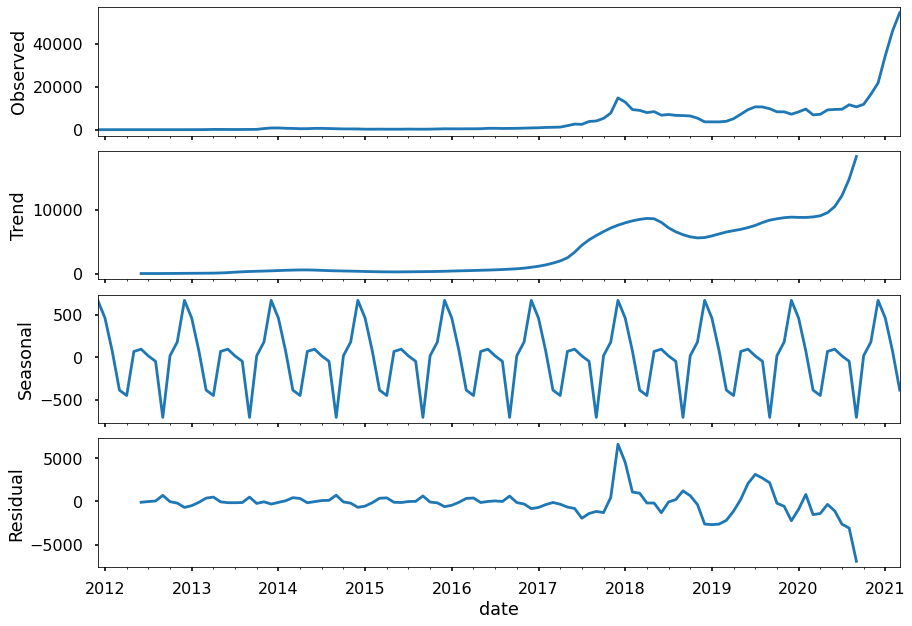

In [ ]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.my_weighted_avg)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.my_weighted_avg)[1])

Dickey–Fuller test: p=0.998862


In [ ]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444364


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

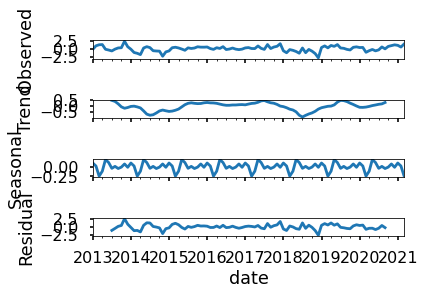

In [ ]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

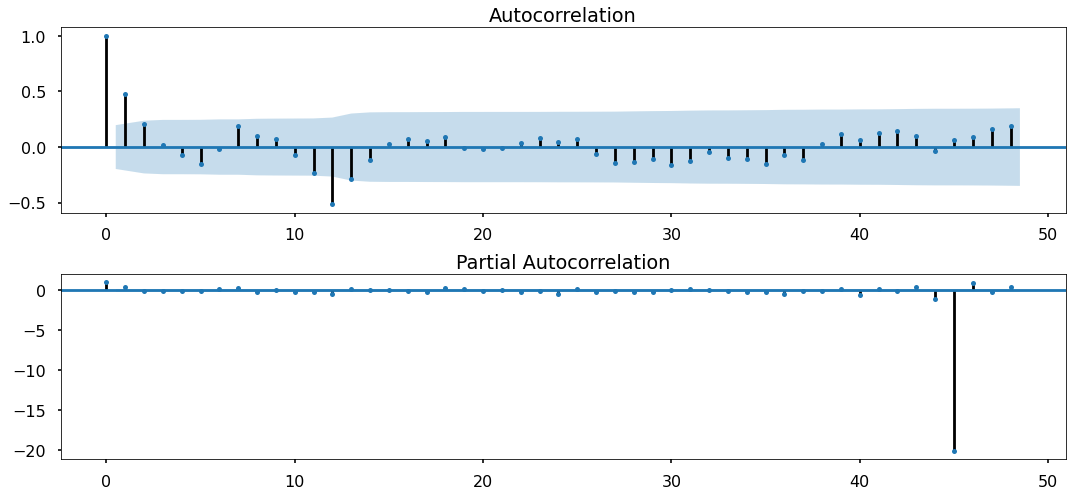

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.609237
21  (1, 0, 1, 1)  174.759006
25  (1, 1, 0, 1)  175.539499
37  (2, 0, 0, 1)  175.546685
7   (0, 1, 0, 1)  175.582990
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 -83.805
Date:                            Mon, 09 May 2022   AIC                            173.609
Time:                                    04:00:35   BIC                            181.395
Sample:                                12-31-2011   HQIC                           176.759
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


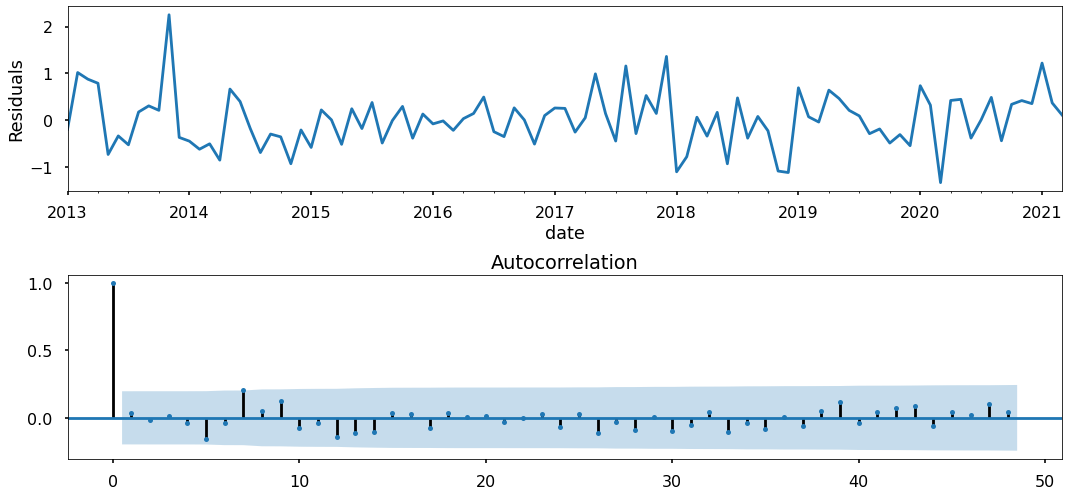

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

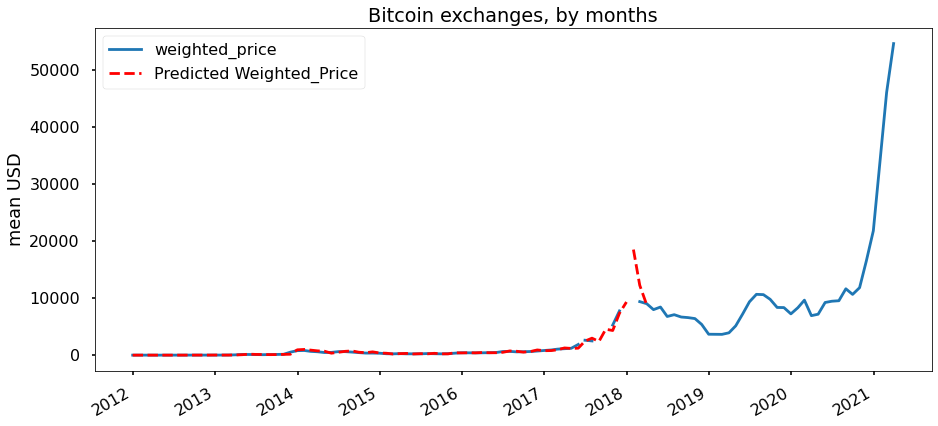

In [ ]:
# Prediction
df_month2 = df_month[['weighted_price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.weighted_price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()